# Spotify Data Analysis: Song Popularity Predictions, Complete Model Benchmarking.

The objective of this notebook is to predict the popularity of a song using a 600k song dataset from Kaggle:
https://www.kaggle.com/marchenrysaintfelix/spotify-600k-song-database/download

We will use a mix of categorical and numerical features from 'tracks.csv' to benchmark several models with Scikit-Learn Pipelines and fine-tune hyperparameters with GridSearchCV. The objective is to minimize the "mean_absolute_error" metric of a numerical target feature.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.metrics import mean_absolute_error

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

# Exploratory Data Analysis

The dataset has 20 features (numerical and categorical) and has nearly 600 000 songs. Let's check for NaN values. The column 'name' is the only column with NaN values and it will be dropped later on as it is of no use for our model:

In [2]:
df = pd.read_csv('Dataset/tracks.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [3]:
df.head(10)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4
5,0BRXJHRNGQ3W4v9frnSfhu,Ave Maria,0,178933,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.227,0.2610,5,-12.343,1,0.0382,0.994,0.247000,0.0977,0.0539,118.891,4
6,0Dd9ImXtAtGwsmsAD69KZT,La Butte Rouge,0,134467,0,['Francis Marty'],['2nuMRGzeJ5jJEKlfS7rZ0W'],1922,0.510,0.3550,4,-12.833,1,0.1240,0.965,0.000000,0.1550,0.7270,85.754,5
7,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,['Mistinguett'],['4AxgXfD7ISvJSTObqm4aIE'],1922,0.563,0.1840,4,-13.757,1,0.0512,0.993,0.000016,0.3250,0.6540,133.088,3
8,0IgI1UCz84pYeVetnl1lGP,Old Fashioned Girl,0,310073,0,['Greg Fieler'],['5nWlsH5RDgFuRAiDeOFVmf'],1922,0.488,0.4750,0,-16.222,0,0.0399,0.620,0.006450,0.1070,0.5440,139.952,4
9,0JV4iqw2lSKJaHBQZ0e5zK,Martín Fierro - Remasterizado,0,181173,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-29,0.548,0.0391,6,-23.228,1,0.1530,0.996,0.933000,0.1480,0.6120,75.595,3


The purpose of the following function is to replace artists names by their popularity quantiles. It was developped for future usage only. This encoding method introduces the concept of artist bias when evaluating a song: a given song will generally be rated higher when the artist is famous.

We will not make use of this function due to lack of detailed information from the dataset author about rating methods and given the purpose of this study (predicting the popularity of a song, based on its acoustic features only).

In [4]:
def encode_artist_popularity(df, num_quantiles=10):
    """
    Select the main artist for each song (first name when list of artists)
    Rank main artists by popularity 
    Replace the 'artists' column by quantiles of popularity for each song
    Return a dataframe with 'artist_ranking' quantile instead of initial 'artists' names.
    
    """
    df['artists'] = df['artists'].apply(eval)
    artists_dict = df.artists.to_dict()

    for i in range(len(artists_dict)):
        artists_dict[i] = artists_dict[i][0]
    
    df['artists'] = pd.DataFrame.from_dict(artists_dict, orient='index')
    
    artists_df = df[['artists', 'popularity']].groupby('artists').sum().sort_values(by='popularity', ascending=False)
    artists_df['artist_ranking'] = pd.qcut(artists_df['popularity'], num_quantiles, labels=False)
    
    data_artists = artists_df.loc[df['artists']].reset_index()
    df['artists'] = data_artists['artist_ranking']
    
    return df

In [5]:
#df = encode_artist_popularity(df, 10)
#df.head(10)

Let's shuffle our dataset and visualize the distribution of the 'popularity' target feature (100 bins for 0-100 ratings):

<AxesSubplot:ylabel='Frequency'>

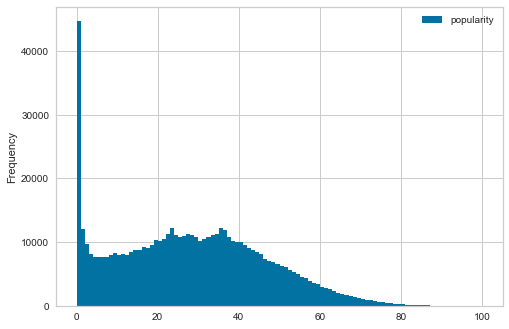

In [6]:
df = df.sample(frac=1).reset_index(drop=True)
df[['popularity']].plot.hist(bins=100)

It seems like a significant amount of songs were not rated, or very rarely/poorly rated (no information about rating methods was provided). Consequently, our distribution appears to be skewed by these outliers. in order to preserve a more Gaussian-like distribution, let's get rid of them so we can learn relevant patterns from the rest of our data:

<AxesSubplot:ylabel='Frequency'>

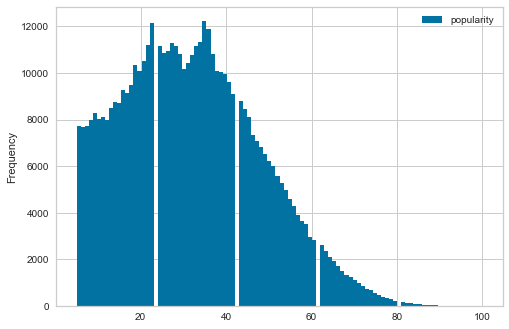

In [7]:
df.drop(df[df['popularity']<5].index, inplace=True)
df[['popularity']].plot.hist(bins=100)

Some songs might have badly encoded/skewed features: getting rid of songs that have 'tempo'==0 (which is technically impossible) and making sure these outliers are not simply spoken files by checking their 'speechiness'.
Also getting rid of songs which have a 'time_signature' of 0 or 1 (which is technically impossible).

In [8]:
df.drop(df[(df['tempo']==0) & (df['speechiness']==0)].index, inplace=True)
df.drop(df[df['time_signature']<2].index, inplace=True)

At this point, as per best practice recommendations, we are going to create a test set called 'test_data' that we will completely set aside in order to avoid 'data snooping bias'. This dataset will allow us to perform evaluation of the final fine-tuned model we will later select. Model selection and performance evaluation will be performed on a subset of 'train_data' called 'val_set' (e.g a validation dataset).

In [9]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

Now let's define our X input matrix and y target vector:

In [10]:
X = train_data[['explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]
X.describe()

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,399435.000000,399435.000000,399435.000000,399435.000000,399435.000000,399435.000000,399435.000000,399435.000000,399435.000000,399435.000000,399435.000000,399435.000000,399435.000000
mean,0.049375,0.571208,0.568324,5.226663,-9.735599,0.654074,0.097682,0.405179,0.083442,0.212073,0.559369,119.413251,3.916284
std,0.216649,0.162858,0.241132,3.525346,4.751867,0.475670,0.165444,0.328042,0.229911,0.184909,0.254859,29.413099,0.332145
min,0.000000,0.055900,0.000020,0.000000,-54.837000,0.000000,0.021600,0.000000,0.000000,0.005720,0.000000,30.506000,3.000000
25%,0.000000,0.463000,0.389000,2.000000,-12.282000,0.000000,0.033400,0.082450,0.000000,0.096600,0.354000,96.480000,4.000000
50%,0.000000,0.584000,0.580000,5.000000,-8.852000,1.000000,0.043200,0.355000,0.000013,0.136000,0.570000,118.211000,4.000000
75%,0.000000,0.690000,0.764000,8.000000,-6.279000,1.000000,0.073400,0.706000,0.002920,0.275000,0.775000,137.455000,4.000000
max,1.000000,0.991000,1.000000,11.000000,4.584000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


Let's use Seaborn capabilities to derive insights from feature correlation. The following plots show no significant correlation between features. Straight parallel lines belong to discrete/categorical features (integer values) that will be processed later on.

In [11]:
#sns.pairplot(X)

In [12]:
y = train_data.popularity.values

# Preprocessing

Now let's cast the categorical columns type as 'category' and then use the sklearn selector() method to create a list of numerical columns and a list of categorical columns:

In [13]:
X.loc[:, ['explicit', 'key', 'mode', 'time_signature']] = X.loc[:, ['explicit', 'key', 'mode', 'time_signature']].astype('category')

/Users/msf/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
numerical_columns_selector = selector(dtype_exclude='category')
categorical_columns_selector = selector(dtype_include='category')

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [15]:
numerical_columns

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [16]:
categorical_columns

['explicit', 'key', 'mode', 'time_signature']

In [17]:
X.dtypes

explicit            category
danceability         float64
energy               float64
key                 category
loudness             float64
mode                category
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
time_signature      category
dtype: object

Now let's define the transformers (preprocessors) for our sklearn pipeline: OneHotEncoder() for categorical columns and StandardScaler() for numerical columns.

In [18]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = MinMaxScaler()

The ColumnTransformer splits the columns of the original dataset based on column names, transforms each subset  by calling the predefined fit_transform and finally concatenates the transformed datasets into a single dataset for training. The same steps will be applied when calling the predict() method.

In [19]:
preprocessor = ColumnTransformer([
    ('One-Hot-Encoder', categorical_preprocessor, categorical_columns),
    ('MinMaxScaler', numerical_preprocessor, numerical_columns)])

Let's define our model (default number of iteration for training = 1000 epochs) and let's visualize our pipeline architecture:

In [20]:
linreg_model = make_pipeline(preprocessor, LinearRegression())
set_config(display='diagram')
linreg_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('One-Hot-Encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['explicit', 'key', 'mode',
                                                   'time_signature']),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo'])])),
                ('linearregression', LinearRegression())])

Let's split the data into train and validation sets with a 80/20 ratio:

In [21]:
train_set, val_set, train_target, val_target = train_test_split(X, y, test_size=0.2, random_state=42)

# Training & prediction analysis

In [22]:
_ = linreg_model.fit(train_set, train_target)

Making predictions on the train set and the validation set, and getting to know our prediction distribution for the validation set:

In [23]:
train_pred = linreg_model.predict(train_set)
val_pred = linreg_model.predict(val_set)

<AxesSubplot:ylabel='Frequency'>

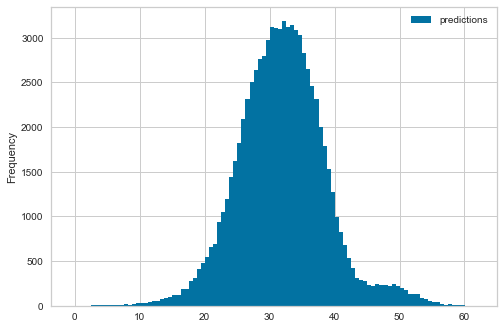

In [24]:
predictions = pd.DataFrame(val_pred, columns=['predictions'])
predictions.plot.hist(bins=100)

In [25]:
predictions.describe()

,predictions
count,79887.000000
mean,31.949558
std,6.777076
min,-0.593750
25%,27.609375
50%,31.859375
75%,35.968750
max,61.898438


Performance metrics for training and test sets: the MAE metric is quite similar for both sets.

In [26]:
mean_absolute_error(train_target, train_pred)

11.833672019735689

In [27]:
mean_absolute_error(val_target, val_pred)

11.796702979677544

Let's plot residuals and observe their Gaussian distributions centered around 0, meaning that a larger portion of predictions are accurate. As expected for the validation set, the distribution is more spread out. We can see some negative predicted values due to linear regression extrapolation.

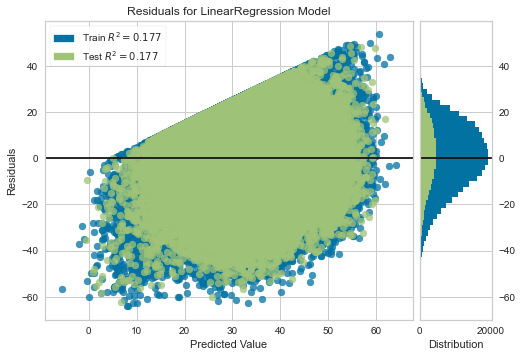

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [28]:
visualizer = ResidualsPlot(linreg_model, hist=True, qqplot=False)
visualizer.fit(train_set, train_target)
visualizer.score(val_set, val_target)
visualizer.show()

Now let's visualize the predictions error and the R-squared metric. The latter is a ratio between the variance explained by the model and the total variance, e.g approximately 17% of the data can be explained by the model. Our data still contains a significant amount fo randomness. In addition, comparing the fitted line and the identity line shows that higher values of popularity (y) have lower prediction scores (y hat), e.g our model has a hard time predicting hits. This makes sense as the training data contains much fewer hit songs (see df['popularity'] distribution above).

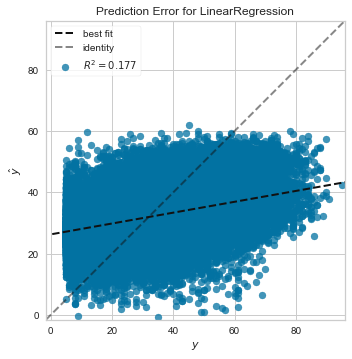

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [29]:
visualizer = PredictionError(linreg_model)
visualizer.fit(train_set, train_target)
visualizer.score(val_set, val_target)
visualizer.show()

Let's have a look at the absolute error in further detail. Mean is approx. 12 and standard deviation is approx. 8.

<AxesSubplot:ylabel='Frequency'>

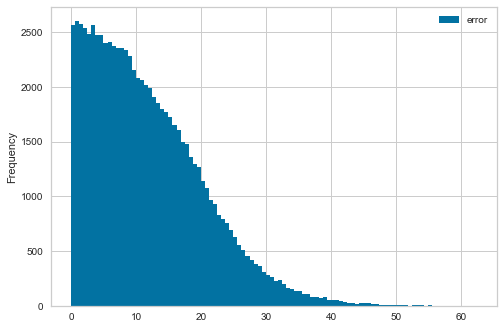

In [30]:
err = abs(val_target - val_pred)
error = pd.DataFrame(err, columns = ['error'])
error.plot.hist(bins=100)

In [31]:
error.describe()

,error
count,79887.000000
mean,11.796703
std,8.573268
min,0.000000
25%,4.906250
50%,10.281250
75%,17.046875
max,62.375000


# Let's train a DecisionTreeRegressor

Let's try and train a different type of model.

In [32]:
from sklearn.tree import DecisionTreeRegressor


tree_model = make_pipeline(preprocessor, DecisionTreeRegressor())
set_config(display='diagram')
tree_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('One-Hot-Encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['explicit', 'key', 'mode',
                                                   'time_signature']),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo'])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [33]:
tree_model.fit(train_set, train_target)
tree_pred = tree_model.predict(train_set)
tree_mae = mean_absolute_error(train_target, tree_pred)
tree_mae

0.23229619711749988

The DecisionTree is most likely overfitting as it fits the training data almost perfectly! Let's evaluate its performance with cross-validation scores.

In [34]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_model, train_set, train_target, scoring='neg_mean_absolute_error', cv=10)

In [35]:
print("Scores: ", tree_scores)
print("Mean: ", tree_scores.mean())
print("Standard deviation: ", tree_scores.std())

Scores:  [-15.54554845 -15.45559302 -15.60035153 -15.59612488 -15.37257418
 -15.44419469 -15.40914839 -15.47744901 -15.54588193 -15.36279447]
Mean:  -15.480966056156594
Standard deviation:  0.08293298349128696


Overfitting confirmed, and the DecisionTree performs even lower than the LinearRegression on validation sets:

In [36]:
linreg_scores = cross_val_score(linreg_model, train_set, train_target, scoring='neg_mean_absolute_error', cv=10)

In [37]:
print("Scores: ", linreg_scores)
print("Mean: ", linreg_scores.mean())
print("Standard deviation: ", linreg_scores.std())

Scores:  [-11.83973557 -11.81843559 -11.85944859 -11.85179806 -11.7922716
 -11.81965508 -11.90232798 -11.81827105 -11.82530356 -11.81989992]
Mean:  -11.834714700996653
Standard deviation:  0.028934460433450226


# Let's train a RandomForestRegressor

Next attempt with Ensemble techniques: a RandomForestRegressor model.

In [38]:
from sklearn.ensemble import RandomForestRegressor

forest_model = make_pipeline(preprocessor, RandomForestRegressor())
set_config(display='diagram')
forest_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('One-Hot-Encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['explicit', 'key', 'mode',
                                                   'time_signature']),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [39]:
forest_model.fit(train_set, train_target)
forest_pred = forest_model.predict(train_set)
forest_mae = mean_absolute_error(train_target, forest_pred)
forest_mae

4.230453386973298

This is a good score for the training set. Let's evaluate the performance on the validation set:

In [40]:
forest_pred = forest_model.predict(val_set)
forest_mae = mean_absolute_error(val_target, forest_pred)
forest_mae

11.116407688174501

The performance is slightly better than the LinearRegression model. Can we improve it?

# Hyperparameter tuning with GridSearchCV

In [41]:
from sklearn.model_selection import GridSearchCV

# Sets of dictionaries defining hyperparameter ranges and values
param_grid = [
    {'n_estimators': [10,30,50], 'max_features': [2, 4, 6]},
    {'bootstrap': [False], 'n_estimators': [10, 30], 'max_features': [3, 4]}
]

Let's define a pipeline combining our preprocessor and a RandomForestRegressor whose best hyperparameters will be identified by GridSearchCV. The option 'refit=True' ensures that the entire dataset will be used to train the best model (stored as 'grid_forest'):

In [42]:
grid_forest = make_pipeline(preprocessor, 
                            GridSearchCV(RandomForestRegressor(), 
                                         param_grid, 
                                         cv=3, 
                                         scoring='neg_mean_absolute_error', 
                                         return_train_score=True, 
                                         refit=True)
                           )

In [43]:
grid_forest.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('One-Hot-Encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['explicit', 'key', 'mode',
                                                   'time_signature']),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=3, estimator=RandomForestRegressor(),
                              param_grid=[{'max_features': [2, 4, 6],
                                           'n_estimators': [10, 30, 50]},
                                          {'bootstrap': [False],
                                           'max_features': [3, 4],
                                           'n_estimators': [10, 30]}],
                              return_train_score=True,
                              scoring='neg_mean_absolute_error'))])

In [44]:
# let's serialize the best model for later use
import joblib

joblib.dump(grid_forest, "my_best_model.pkl")

['my_best_model.pkl']

# Final evaluation of the system on the test set

In [45]:
# Retrieve the best model by deserializing it
my_model_loaded = joblib.load("my_best_model.pkl")

The test set was set aside from the beginning and consists of data that the final model has literally never seen before. Therefore, evaluating performance on it is comparable to real life conditions. Firstly, let's format our data by selecting the desired columns, then calling 'predict()' on the model will automatically preprocess the test data with our previous pipeline transformers.

In [46]:
X_test = test_data[['explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]
X_test.loc[:, ['explicit', 'key', 'mode', 'time_signature']] = X_test.loc[:, ['explicit', 'key', 'mode', 'time_signature']].astype('category')

y_test = test_data.popularity.values

/Users/msf/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [47]:
final_predictions = my_model_loaded.predict(X_test)

In [48]:
mean_absolute_error(y_test, final_predictions)

11.18080435422084

This result is final and should not trigger any more model tweaking, or it will fail to generalize to new data.